In [1]:
from __future__ import division
%pylab inline
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
pd.options.display.max_colwidth = 128
pylab.rcParams['figure.figsize'] = 12, 5
# with mpl.rc_context({"figure.figsize": (5, 5)}):
# with mpl.rc_context({"lines.linewidth": 2, "lines.color": "r"}):

Populating the interactive namespace from numpy and matplotlib


In [13]:
from skyfield.api import load, Topos
ts = load.timescale()
planets = load('de421.bsp')
earth, sun = planets['earth'], planets['sun']
sf = earth + Topos('37.7749 N', '122.4194 W')
TZ = -7
t6 = ts.utc(2018, 8, 19, 6 - TZ)
alt, az, distance = sf.at(t6).observe(sun).apparent().altaz()
print(alt)

-06deg 12' 11.4"


In [14]:
t7 = ts.utc(2018, 8, 19, 7 - TZ)
alt, az, distance = sf.at(t7).observe(sun).apparent().altaz()
print(alt)

05deg 08' 18.0"


```
plot([t6, t7], [?, ?])
```

In [19]:
t7 = ts.utc(2018, 8, 19, 7 - TZ)
alt, az, distance = sf.at(t7).observe(sun).apparent().altaz()
print(alt)

05deg 08' 18.0"


In [28]:
def f(hour):
    t = ts.utc(2018, 8, 19, array(hour) - TZ)
    alt, az, distance = sf.at(t).observe(sun).apparent().altaz()
    return alt.degrees

f(7)

5.1383290446332239

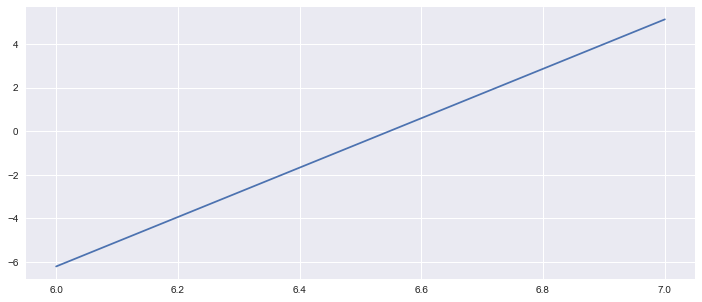

In [29]:
plot([6, 7], [f(6), f(7)])

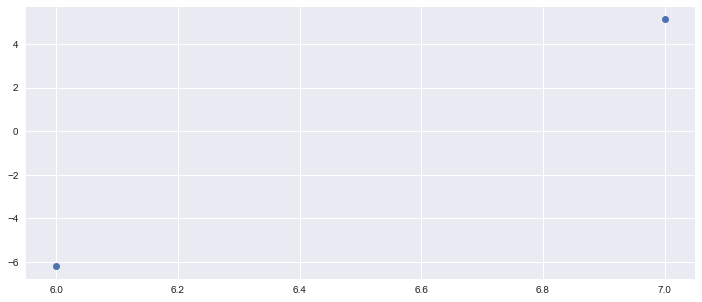

In [30]:
plot([6, 7], [f(6), f(7)], 'o')

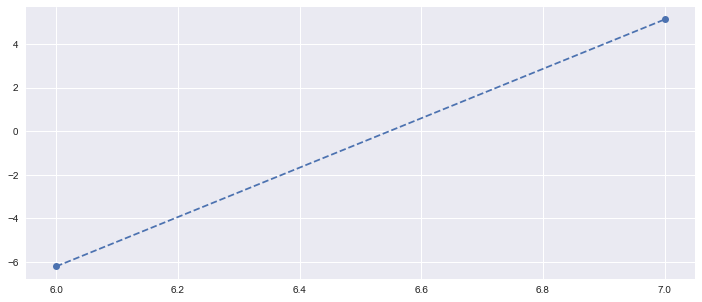

In [31]:
plot([6, 7], [f(6), f(7)], 'o--')

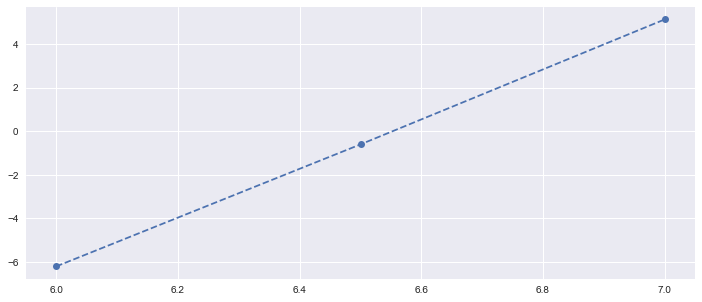

In [33]:
h = [6, 6.5, 7]
plot(h, f(h), 'o--')

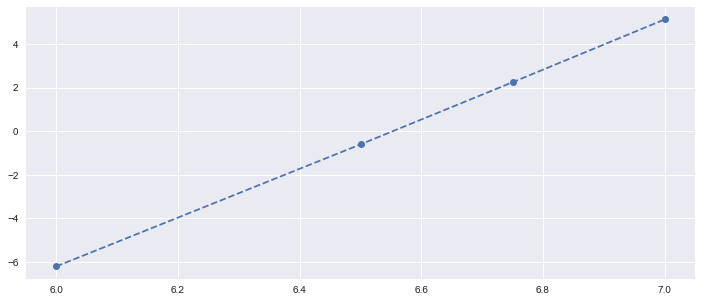

In [34]:
h = [6, 6.5, 6.75, 7]
plot(h, f(h), 'o--')

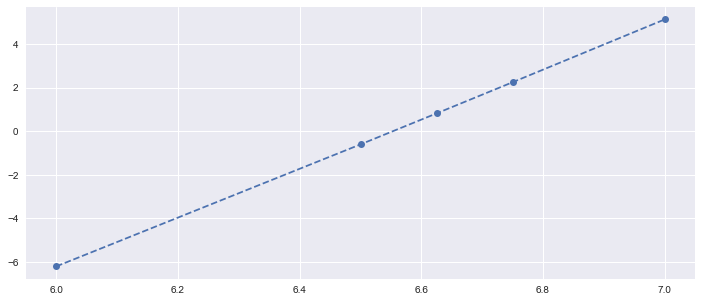

In [35]:
h = [6, 6.5, 6.625, 6.75, 7]
plot(h, f(h), 'o--')

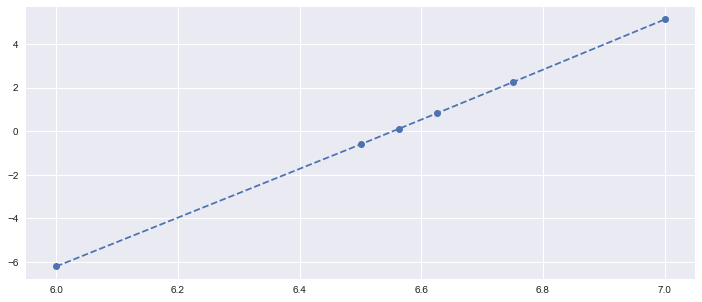

In [36]:
h = [6, 6.5, 6.5625, 6.625, 6.75, 7]
plot(h, f(h), 'o--')

In [47]:
h0 = 6
h1 = 7
while h1 - h0 > 1/3600:
    hh = (h1 + h0) / 2
    if f(hh) > 0:
        h1 = hh
    else:
        h0 = hh

0.00135074888369 degrees = 4.86269598129 arcseconds


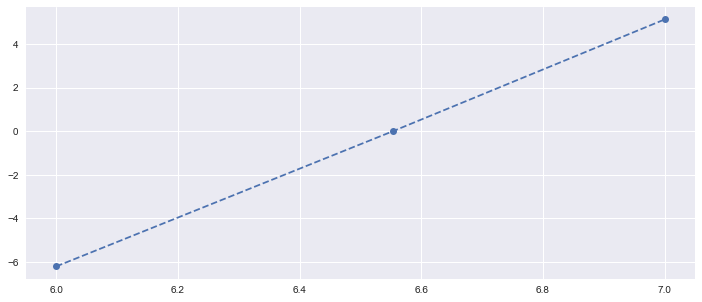

In [41]:
h = [6, hh, 7]
print(f(hh), 'degrees =', f(hh) * 3600, 'arcseconds')
plot(h, f(h), 'o--')

Q: At what expense?

In [45]:
interval_start = 7 - 6
interval_end = 1/3600
print(log10(interval_start / interval_end))
print(log(interval_start / interval_end) / log(2))

3.55630250077
11.8137811912


In [ ]:
h0 = 6
h1 = 7
while h1 - h0 > 1/3600:
    hh = (h1 + h0) / 2  # <---
    if f(hh) > 0:
        h1 = hh
    else:
        h0 = hh

In [49]:
hh = (h1 + h0) / 2
hh = 0.5 * h1 + 0.5 * h0
hh = 0.4 * h1 + 0.6 * h0
hh = h0 + f(h0) * (f(h1) - f(h0))

In [69]:
h0 = 6
h1 = 7
while h1 - h0 > 1/3600:
    fraction1 = 0.5
    #print(h0 * 0.5, h1 * 0.5)
    hh = fraction1 * h1 + (1 - fraction1) * h0
    print(hh, h1 - h0)
    #break
    if f(hh) > 0:
        h1 = hh
    else:
        h0 = hh

6.5 1
6.75 0.5
6.625 0.25
6.5625 0.125
6.53125 0.0625
6.546875 0.03125
6.5546875 0.015625
6.55078125 0.0078125
6.552734375 0.00390625
6.5537109375 0.001953125
6.55322265625 0.0009765625
6.552978515625 0.00048828125


In [71]:
h0 = 6
h1 = 7
while h1 - h0 > 1/3600:
    num = h0 * f(h1) - h1 * f(h0)
    denom = f(h1) - f(h0)
    hh = num / denom
    if f(hh) > 0:
        h1 = hh
    else:
        h0 = hh
    print(hh, h1-h0)

6.54694463859 0.453055361411
6.5528044219 0.447195578104
6.55285933664 0.447140663355
6.5528598582 0.447140141797
6.55285985941 0.447140140588
6.55285986062 0.447140139379
6.55285986183 0.447140138171
6.55285986304 0.447140136962
6.55285986425 1.20867937881e-09


In [79]:
h0 = 6
h1 = 7
while abs(h1 - h0) > 1/3600:
    num = h0 * f(h1) - h1 * f(h0)
    denom = f(h1) - f(h0)
    hh = num / denom
    h0, h1 = h1, hh
    print(h0, h1, h1-h0)
print(divmod(h1, 60))

7 6.54694463859 -0.453055361411
6.54694463859 6.5528044219 0.00585978330672
6.5528044219 6.55285986302 5.54411210123e-05
(0.0, 6.5528598630170967)


In [82]:
h0 = 13
h1 = 14
while abs(h1 - h0) > 1/3600:
    num = h0 * f(h1) - h1 * f(h0)
    denom = f(h1) - f(h0)
    hh = num / denom
    h0, h1 = h1, hh
    print(h0, h1, h1-h0)

14 46.7330269248 32.7330269248
46.7330269248 36.3522877544 -10.3807391704
36.3522877544 43.414275601 7.06198784665
43.414275601 44.0471466827 0.632871081615
44.0471466827 43.8577868537 -0.189359828971
43.8577868537 43.8560188689 -0.00176798479261
43.8560188689 43.8560266582 7.789339449e-06


14 46.7330269248 32.7330269248
46.7330269248 36.3522877544 -10.3807391704
36.3522877544 43.414275601 7.06198784665
43.414275601 44.0471466827 0.632871081615
44.0471466827 43.8577868537 -0.189359828971
43.8577868537 43.8560188689 -0.00176798479261
43.8560188689 43.8560266582 7.789339449e-06


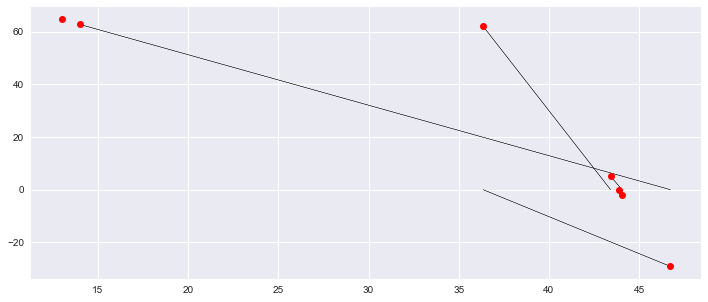

In [88]:
h0 = 13
h1 = 14
while abs(h1 - h0) > 1/3600:
    plot(h0, f(h0), 'ro')
    num = h0 * f(h1) - h1 * f(h0)
    denom = f(h1) - f(h0)
    hh = num / denom
    arrow(h1, f(h1), (hh - h1), -f(h1))
    h0, h1 = h1, hh
    print(h0, h1, h1-h0)

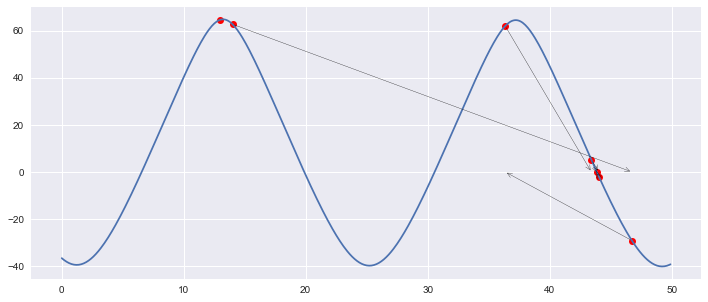

In [122]:
h0 = 13
h1 = 14
i = 0
while abs(h1 - h0) > 1/3600:
    i += 1
    plot(h0, f(h0), 'ro')
    num = h0 * f(h1) - h1 * f(h0)
    denom = f(h1) - f(h0)
    hh = num / denom
    #arrow(h1, f(h1), (hh - h1), -f(h1), length_includes_head=True,
    #      head_width=2)
    annotate('',
             (hh, 0),
             (h1, f(h1)), 
             #((hh - h1), -f(h1)),
            xycoords='data',
            #arrowprops={'headwidth':10})#{'arrowstyle':'->'})
            arrowprops={'arrowstyle':'->'})#, patchA=10'})
    h0, h1 = h1, hh

t = arange(0, 50, 0.1)
plot(t, f(t))

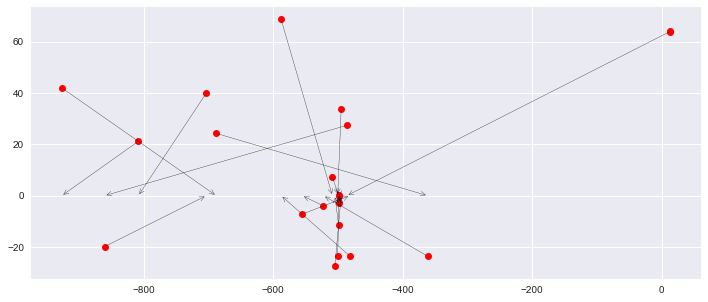

In [136]:
fig, ax = plt.subplots()
h0 = 12.7
h1 = 13.7
i = 0
while abs(h1 - h0) > 1/3600:
    i += 1
    plot(h0, f(h0), 'ro')
    num = h0 * f(h1) - h1 * f(h0)
    denom = f(h1) - f(h0)
    hh = num / denom
    #arrow(h1, f(h1), (hh - h1), -f(h1), length_includes_head=True,
    #      head_width=2)
    ax.annotate('',
             (hh, 0),
             (h1, f(h1)), 
             #((hh - h1), -f(h1)),
            xycoords='data',
            #arrowprops={'headwidth':10})#{'arrowstyle':'->'})
            arrowprops={'arrowstyle':'->'})#, patchA=10'})
    h0, h1 = h1, hh

In [140]:
print('1,000 hours ≈ {:.1f} days'.format(1000 / 24))

1,000 hours ≈ 41.7 days


In [141]:
f(t)

array([ 22.14221493,  23.30382351,  24.46869227, ..., -35.10816356,
       -35.64281256, -36.14613498])

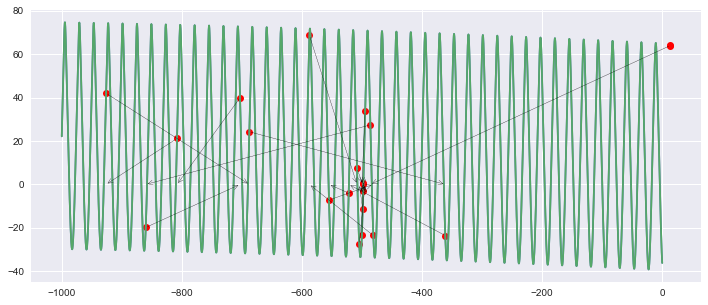

In [138]:
t = arange(-1e3, 0, 0.1)
ax.plot(t, f(t))
fig

secant method is
difficult to control

*but*

efficient

does safety have to be expensive?

In [142]:
h0 = 6
h1 = 7
while h1 - h0 > 1/3600:
    fraction1 = 0.5
    hh = fraction1 * h1 + (1 - fraction1) * h0
    print(hh, h1 - h0)
    if f(hh) > 0:
        h1 = hh
    else:
        h0 = hh

6.5 1
6.75 0.5
6.625 0.25
6.5625 0.125
6.53125 0.0625
6.546875 0.03125
6.5546875 0.015625
6.55078125 0.0078125
6.552734375 0.00390625
6.5537109375 0.001953125
6.55322265625 0.0009765625
6.552978515625 0.00048828125


In [149]:
a = [7]
%time f(6)
%time f(a)
%time f(a * 2)

CPU times: user 17.4 ms, sys: 0 ns, total: 17.4 ms
Wall time: 13 ms
CPU times: user 22.1 ms, sys: 3.54 ms, total: 25.6 ms
Wall time: 12.8 ms
CPU times: user 27.6 ms, sys: 0 ns, total: 27.6 ms
Wall time: 13.6 ms


array([ 5.13832904,  5.13832904])

(0, 0.01680014133453369)

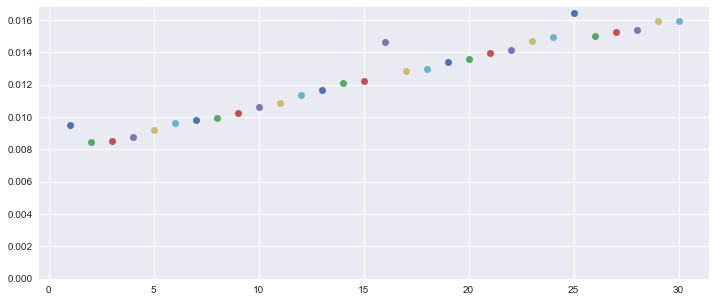

In [158]:
from time import time
for i in range(1, 30+1):
    t0 = time()
    f([7] * i)
    dt = time() - t0
    plot(i, dt, 'o')
ylim(0, None)

In [191]:
h0 = 6
h1 = 7
h = linspace(h0, h1, 5)
h

array([ 6.  ,  6.25,  6.5 ,  6.75,  7.  ])

In [192]:
f(h)

array([-6.20317463, -3.42192169, -0.60100898,  2.25410573,  5.13832904])

In [193]:
f(h) > 0

array([False, False, False,  True,  True], dtype=bool)

In [195]:
argmax(f(h) > 0)

3

In [197]:
h0, h1 = 6, 7
while h1 - h0 > 1/3600:
    h = linspace(h0, h1, 5)
    print(h)
    i = argmax(f(h) > 0)
    h0, h1 = h[i-1], h[i]

[ 6.    6.25  6.5   6.75  7.  ]
[ 6.5     6.5625  6.625   6.6875  6.75  ]
[ 6.5       6.515625  6.53125   6.546875  6.5625  ]
[ 6.546875    6.55078125  6.5546875   6.55859375  6.5625    ]
[ 6.55078125  6.55175781  6.55273438  6.55371094  6.5546875 ]
[ 6.55273438  6.55297852  6.55322266  6.5534668   6.55371094]


In [200]:
def secant_search(h0, h1, epsilon, f):
    while abs(h1 - h0) > epsilon:
        f0, f1 = f(h0), f(h1)
        h = (h0 * f1 - h1 * f0) / (f1 - f0)
        h0, h1 = h1, h
    return h

secant_search(6, 7, 1/3600, f)

6.5528598630170967

In [228]:
def battery_search(h0, h1, epsilon, length, f):
    while h1 - h0 > epsilon:
        h = linspace(h0, h1, length)
        i = argmax(f(h) > 0)
        h0, h1 = h[i-1], h[i]
    return h0
        
battery_search(6, 7, 1/3600, 5, f)

6.552734375

In [229]:
%time secant_search(6, 7, 1/3600, f)
%time battery_search(6, 7, 1/3600, 3, f)
%time battery_search(6, 7, 1/3600, 5, f)
%time battery_search(6, 7, 1/3600, 9, f)

CPU times: user 121 ms, sys: 4.05 ms, total: 125 ms
Wall time: 62.9 ms
CPU times: user 216 ms, sys: 19.8 ms, total: 236 ms
Wall time: 118 ms
CPU times: user 111 ms, sys: 0 ns, total: 111 ms
Wall time: 55.2 ms
CPU times: user 90.5 ms, sys: 0 ns, total: 90.5 ms
Wall time: 44.9 ms


6.552734375

In [230]:
def secant_search(h0, h1, epsilon, f):
    while abs(h1 - h0) > epsilon:
        f0, f1 = f(h0), f(h1)
        h = (h0 * f1 - h1 * f0) / (f1 - f0)
        h0, h1 = h1, h
    return h

In [231]:
def secant_search2(h0, h1, epsilon, f):
    while abs(h1 - h0) > epsilon:
        f0, f1 = f([h0, h1])
        h = (h0 * f1 - h1 * f0) / (f1 - f0)
        h0, h1 = h1, h
    return h

In [233]:
%time secant_search(6, 7, 1/3600, f)
%time secant_search2(6, 7, 1/3600, f)
%time battery_search(6, 7, 1/3600, 3, f)
%time battery_search(6, 7, 1/3600, 5, f)
%time battery_search(6, 7, 1/3600, 9, f)

CPU times: user 88.3 ms, sys: 3.78 ms, total: 92.1 ms
Wall time: 46 ms
CPU times: user 59.4 ms, sys: 0 ns, total: 59.4 ms
Wall time: 29.7 ms
CPU times: user 219 ms, sys: 3.9 ms, total: 223 ms
Wall time: 112 ms
CPU times: user 112 ms, sys: 0 ns, total: 112 ms
Wall time: 55.5 ms
CPU times: user 105 ms, sys: 0 ns, total: 105 ms
Wall time: 52.3 ms


6.552734375

(0, 0.12310386896133423)

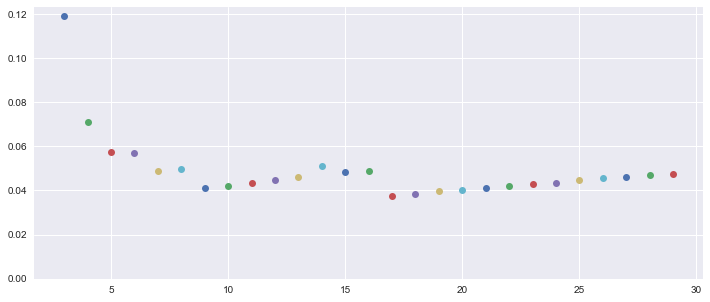

In [234]:
for i in range(3, 30):
    t0 = time()
    battery_search(6, 7, 1/3600, i, f)
    dt = time() - t0
    plot(i, dt, 'o')
ylim(0)

(0, 0.22795557975769043)

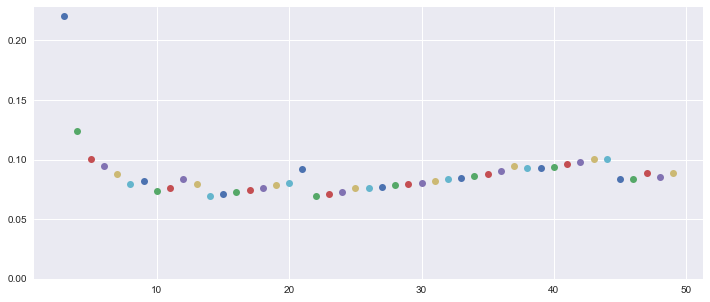

In [237]:
for i in range(3, 50):
    t0 = time()
    battery_search(6, 7, 1/3600/1000, i, f)
    dt = time() - t0
    plot(i, dt, 'o')
ylim(0)

Have we found sunrise?

In [247]:
h0 // 1, h0 * 60 // 1 % 60, h0 * 3600 // 1 % 60

(6.0, 33.0, 9.0)

No

<img src="sunrise-form.png">

<table class="tableA">
            <tr class="trA"><td class="tdAleft">Sunday, August 19, 2018</td>
            <td class="tdAright">Pacific Daylight Time</td></tr></table><table>
          <tr style="font-size:20px">
          <th colspan="2">Sun</th>
          </tr>
            <tr><td>Begin civil twilight</td><td>6:01 a.m.</td></tr>
            <tr><td>Sunrise</td><td>6:29 a.m.</td></tr>
            <tr><td>Sun transit</td><td>1:13 p.m.</td></tr>
            <tr><td>Sunset</td><td>7:57 p.m.</td></tr>
            <tr><td>End civil twilight</td><td>8:25 p.m.</td></tr><tr style="font-size:20px"><th colspan="2">Moon</th></tr>
               <tr><td>Moonset</td><td>12:50 a.m.</td></tr>
               <tr><td>Moonrise</td><td>3:15 p.m.</td></tr>
               <tr><td>Moon transit</td><td>8:24 p.m.</td></tr>
         <tr><td>Moonset</td><td>1:30 a.m. on following day</td></tr></table>

“For computational purposes, sunrise or sunset is defined to occur when the geometric zenith distance of center of the Sun is 90.8333 degrees.”

http://aa.usno.navy.mil/faq/docs/RST_defs.php

In [274]:
def sunrise(t):
    alt, az, distance = sf.at(t).observe(sun).apparent().altaz()
    return alt.degrees > -0.8333

def battery_search(ts, t0, t1, epsilon, f):
    jd0, jd1 = t0.tt, t1.tt
    while jd1 - jd0 > epsilon:
        jd = linspace(jd0, jd1, 16)
        t = ts.tt(jd=jd)
        i = argmax(f(t))
        jd0, jd1 = jd[i-1], jd[i]
    return ts.tt(jd=jd0)

In [275]:
battery_search(ts, ts.utc(2018, 8, 19, 6 - TZ),
                   ts.utc(2018, 8, 19, 7 - TZ), 1e-8, sunrise)

<Time tt=2458350.062448>

In [276]:
t = battery_search(ts, ts.utc(2018, 8, 19, 6 - TZ),
                       ts.utc(2018, 8, 19, 7 - TZ), 1e-8, sunrise)

t.utc_jpl()

'A.D. 2018-Aug-19 13:28:46.3211 UT'

<table class="tableA">
          <tr style="font-size:20px">
          <th colspan="2">Sun</th>
          </tr>
            <tr><td>Sunrise</td><td>6:29 a.m.</td></tr>
</table>